먼저 필요한 도구들을 불러오자.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.utils.data import DataLoader, SubsetRandomSampler

transform을 생성하고 각각의 CIFAR10 데이터셋을 불러온다.

In [2]:
train_transform = transforms.Compose([transforms.ToTensor(),
                                      transforms.Resize((256, 256)),
                                      transforms.RandomCrop(224),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Resize((224, 224)),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


In [3]:
train_data = dsets.CIFAR10(root='CIFAR10',
                           train=True,
                           transform=train_transform,
                           download=True)

test_data = dsets.CIFAR10(root='CiFAR10',
                          train=False,
                          transform=test_transform,
                          download=True)

Files already downloaded and verified
Files already downloaded and verified


데이터 구조를 확인하자.

In [4]:
print(f'train image 개수: {len(train_data)}')
print(f'test image 개수: {len(test_data)}')

train image 개수: 50000
test image 개수: 10000


In [5]:
# 각 sample의 구조
train_data[0][0]

tensor([[[-0.7608, -0.7608, -0.7608,  ...,  0.0584,  0.0513,  0.0443],
         [-0.7529, -0.7529, -0.7529,  ...,  0.0536,  0.0475,  0.0413],
         [-0.7451, -0.7451, -0.7451,  ...,  0.0489,  0.0436,  0.0383],
         ...,
         [ 0.4044,  0.4044,  0.4044,  ..., -0.3494, -0.2635, -0.1776],
         [ 0.4015,  0.4015,  0.4015,  ..., -0.2910, -0.2088, -0.1265],
         [ 0.3985,  0.3985,  0.3985,  ..., -0.2325, -0.1540, -0.0754]],

        [[-0.8064, -0.8064, -0.8064,  ..., -0.2547, -0.2600, -0.2654],
         [-0.8054, -0.8054, -0.8054,  ..., -0.2640, -0.2684, -0.2728],
         [-0.8044, -0.8044, -0.8044,  ..., -0.2733, -0.2767, -0.2801],
         ...,
         [ 0.1025,  0.1025,  0.1025,  ..., -0.5844, -0.5054, -0.4264],
         [ 0.1074,  0.1074,  0.1074,  ..., -0.5211, -0.4454, -0.3698],
         [ 0.1123,  0.1123,  0.1123,  ..., -0.4578, -0.3854, -0.3131]],

        [[-0.8569, -0.8569, -0.8569,  ..., -0.5677, -0.5714, -0.5752],
         [-0.8608, -0.8608, -0.8608,  ..., -0

In [6]:
# 이미지 크기
print(train_data[0][0].shape)

torch.Size([3, 224, 224])


이미지를 몇 개 그래보자

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


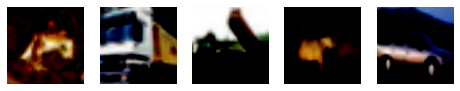

In [7]:
import matplotlib.pyplot as plt
import numpy as np
fig, axs = plt.subplots(1, 5, figsize = (8, 2))

for i in range(5):
  img = train_data[i][0].numpy()
  axs[i].imshow(np.transpose(img, (1, 2, 0)))
  axs[i].axis('off')
plt.show()

train, test datset의 dataloader를 생성하자.

In [8]:
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, drop_last=True)

In [9]:
print(len(train_loader))

1562


 GPU 설정을 해주자.

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(42)
if device == 'cuda':
  torch.cuda.manual_seed(42)
  torch.cuda.manual_seed_all(42)

모델을 설계하자.

In [11]:
models_layer = {
    'VGG11' : [64, 'M', 128, 'M', 256, 256, 'M', 512,512, 'M',512,512,'M'],
    'VGG13' : [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512,512, 'M', 512,512,'M'],
    'VGG16' : [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512,'M'],
    'VGG19' : [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M']
}

In [12]:
class VGGNet(nn.Module): # 모델 구조 설계
  def __init__(self, model, num_classes, init_weights):
    super().__init__()
    self.model = model
    self.conv_layer = self.create_conv_layer(models_layer[self.model])

    self.fc_layer = nn.Sequential(nn.Dropout(0.5),
                                   nn.Linear(512*7*7, 4096),
                                   nn.ReLU(),
                                   nn.Dropout(0.5),
                                   nn.Linear(4096, 4096),
                                   nn.ReLU(),
                                   nn.Linear(4096, num_classes))

    if init_weights:
      self.initialize_weights()

  def forward(self, x):
        x = self.conv_layer(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layer(x)
        return x

  def initialize_weights(self):
    for m in self.modules():
        if isinstance(m, nn.Conv2d):
          nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
          if m.bias is not None:
            nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.BatchNorm2d):
          nn.init.constant_(m.weight, 1)
          nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.Linear):
          nn.init.normal_(m.weight, 0, 0.01)
          nn.init.constant_(m.bias, 0)

  def create_conv_layer(self, layers):
    result = []                       # conv_layer를 쌓아줄 리스트
    in_channel = 3                    # 처음 입력 채널

    for layer in layers:
      if type(layer) == int:          # Conv Layer
        out_channel = layer           
        result += [nn.Conv2d(in_channel, out_channel, kernel_size=(3,3), stride=1, padding=1),
                           nn.BatchNorm2d(out_channel),
                           nn.ReLU()]
        in_channel = layer
      elif layer == 'M':
        result += [nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))]
    
    return nn.Sequential(*result)

In [13]:
model = VGGNet('VGG16', 10, True).to(device) # 모델 선언

loss함수와 optimizer를 선언하자.

In [14]:
learning_rate = 0.01
momentum = 0.9
weight_decay = 0.00005

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

모델을 학습시키자. <br>
학습이 너무 오래걸려서 epoch는 5회만 수행했다.

In [15]:
from tqdm.auto import tqdm
model.train()
epochs = 5
total_batch = len(train_loader)
for epoch in tqdm(range(epochs)):
  avg_cost = 0
  for x, y in train_loader:
    x = x.to(device)
    y = y.to(device)

    hypothesis = model(x)
    cost = criterion(hypothesis, y)

    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    avg_cost += cost/total_batch
  
  print('[Epoch: {:>4}] cost = {:>.9}'.format(epoch + 1, avg_cost))

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch:    1] cost = 1.89593577
[Epoch:    2] cost = 1.3779012
[Epoch:    3] cost = 1.04593599
[Epoch:    4] cost = 0.843697369
[Epoch:    5] cost = 0.711792231


학습한 모델을 평가하자

In [20]:
model.eval()

with torch.no_grad():
  accuracy = 0
  for x, y in test_loader:
    x = x.to(device)
    y = y.to(device)
    
    prediction = model(x)
    _, prediction = torch.max(prediction, 1)
    correct_prediction = (prediction == y)
    accuracy += correct_prediction.sum() / len(test_data)
  print('Accuracy:', accuracy.item())

Accuracy: 0.7732999920845032


## <strong> 참고 </strong>

<h3> <strong> 1. model.modules() </strong> </h3>

model의 modules 속성을 사용하면 model의 모든 층을 살펴볼 수 있으며 이를 이용해서 각각의 층을 초기화할 수 있다.

In [23]:
vgg_11 = VGGNet('VGG11', 10, True)

In [24]:
for i in vgg_11.modules():
  if isinstance(i, nn.Conv2d):
    print(i)

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


In [25]:
for i in vgg_11.modules():
  if isinstance(i, nn.Linear):
    print(i)

Linear(in_features=25088, out_features=4096, bias=True)
Linear(in_features=4096, out_features=4096, bias=True)
Linear(in_features=4096, out_features=10, bias=True)


<h3> <strong> 2. torch.nn.init의 몇몇 메소드 정리 </strong> </h3>

* **torch.nn.init.constant_(tensor, val)** <br>
Tensor를 val로 채워 넣는다.
* **torch.nn.init.uniform_(tensor, a=0.0, b=1.0)** <br>
Tensor를 uniform distribution (a, b)에서 값을 뽑아 채운다.
* **torch.nn.init.kaiming_normal_(tensor, mode='fan_in', nonlinearity='leaky relu')** <br>
mode로는 'fan_in' 혹은 'fan_out'을 사용할 수 있다. <br> 아래 수식에 맞는 std를 계산해 $(0, std^2)$에 맞는 distribution에서 값을 뽑는다. <br>
$std = \frac{gain}{\sqrt{fan\,mode}}$

[torch.nn.init document 링크](https://pytorch.org/docs/stable/nn.init.html)